In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch

from hmr4d.dataset.pure_motion.amass import AmassDataset #52,788 samples
from hmr4d.dataset.pure_motion.utils import augment_betas, interpolate_smpl_params, rotate_around_axis
from hmr4d.dataset.pure_motion.cam_traj_utils import CameraAugmentorV11
from hmr4d.utils.body_model import BodyModelSMPLH, BodyModelSMPLX
from hmr4d.utils.body_model.smplx_lite import SmplxLiteCoco17, SmplxLiteSmplN24
from hmr4d.utils.body_model.utils import smpl_to_openpose

from hmr4d.utils.geo.hmr_global import get_c_rootparam, get_R_c2gv, get_tgtcoord_rootparam, get_T_w2c_from_wcparams
from hmr4d.utils.geo.hmr_cam import create_camera_sensor
from hmr4d.utils.geo_transform import compute_cam_angvel, apply_T_on_points, move_to_start_point_face_z
from hmr4d.utils.net_utils import get_valid_mask
from hmr4d.utils.wis3d_utils import convert_motion_as_line_mesh
from hmr4d.utils.video_io_utils import save_video, get_writer
from hmr4d.utils.vis.renderer import Renderer, get_global_cameras_static, get_ground_params_from_points
from hmr4d.utils.vis.renderer_utils import simple_render_mesh

# [12/23 15:45:21][INFO] [AMASS] 18086 sequences. Elapsed: 2.35s
# [12/23 15:45:21][INFO] [AMASS] has 64.7 hours motion -> Resampled to 52788 samples.
# [12/23 15:40:11][INFO] [BEDLAM] 37537 sequences. 
# [12/23 15:40:24][INFO] [H36M] 600 sequences. Elapsed: 0.61s
# [12/23 15:40:25][INFO] [H36M] has 8.7 hours motion -> Resampled to 6196 samples. 
# [12/23 15:46:37][INFO] [3DPW] has 7.5 minutes motion -> Resampled to 88 samples. 

device = 'cuda:0'

In [2]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).to(device)
smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).to(device)
smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").to(device)
faces_smpl = torch.from_numpy((smpl.faces).astype("int")).unsqueeze(0).to(device)
faces_smplx = torch.from_numpy((smplx.faces).astype("int")).unsqueeze(0).to(device)
J_regressor = torch.load("hmr4d/utils/body_model/smpl_neutral_J_regressor.pt").to(device)

smplx_lite = SmplxLiteSmplN24()
smplx_coco = SmplxLiteCoco17().to(device)

/tmp/ipykernel_724787/4044207151.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").to(device)
/tmp/

In [3]:
# Sample Batch from Dataset
dataset = AmassDataset()

np.random.seed(4)
batch = dataset[5]
print(batch['meta'])

length = batch['length']
K = batch['K_fullimg'][0].to(device)
width, height = int(K[0,2])*2, int(K[1,2])*2

[01/13 15:00:55][INFO] [AMASS] Loading from inputs/AMASS/hmr4d_support/smplxpose_v2.pth ...
[01/13 15:00:58][INFO] [AMASS] 18086 sequences. Elapsed: 2.93s
[01/13 15:00:58][INFO] [AMASS] has 64.7 hours motion -> Resampled to 52788 samples.


{'data_name': 'amass', 'idx': 5, 'vid': 'inputs/smplx_amass/smplxn_raw/Transitions/Transitions/mazen_c3d/crawl_push_stageii.npz', 'start_end': (129, 255)}


In [ ]:
# Render Test -- Camera, SMPL-X
smpl_params_c = {k:v.to(device) for k,v in batch['smpl_params_c'].items()}
verts = smplx(**smpl_params_c).vertices

renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K)

writer = get_writer('tmp.mp4', fps=30, crf=23)
for i in tqdm(range(length)):
    img = renderer_c.render_mesh(verts[i])
    writer.write_frame(img)
writer.close()

smpl_params_gb = {k: v.to(device) for k,v in batch['smpl_params_w'].items()}
smplx_out = smplx(**smpl_params_gb)
pred_ay_verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in smplx_out.vertices])
pred_gb_verts, pred_gb_joints = move_to_start_point_face_z(pred_ay_verts, J_regressor)

global_R, global_T, global_lights = get_global_cameras_static(
    pred_gb_joints.cpu(), beta=2.0, cam_height_degree=20, target_center_height=1.0,
)
_, _, K = create_camera_sensor(width, height, 24)
renderer_gb = Renderer(width, height, device="cuda", faces=faces_smpl[0], K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(pred_gb_joints[:, 0], pred_gb_verts)
renderer_gb.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8

writer = get_writer(f'tmp2.mp4', fps=30, crf=23)
for i in tqdm(range(batch['length']), desc=f"Rendering Global"):
    # img_overlay_pred = renderer.render_mesh(verts[i].cuda(), bg, vertex_colors, VI=1)
    cameras = renderer_gb.create_camera(global_R[i], global_T[i])
    img_gb = renderer_gb.render_with_ground(pred_gb_verts[[i]], color[None], cameras, global_lights)
    writer.write_frame(img_gb)
writer.close()

Rendering Global: 100%|██████████| 120/120 [00:04<00:00, 26.55it/s]


In [13]:
# Render Test -- World (Random Camera), Skeleton
w_j3d = smplx_out.joints.cpu()

wham_cam_augmentor = CameraAugmentorV11()
T_w2c = wham_cam_augmentor(w_j3d, length, "trackpush") 
c_j3d = apply_T_on_points(w_j3d[:,:22], T_w2c)
verts, faces, vertex_colors = convert_motion_as_line_mesh(c_j3d)
renderer_stick = Renderer(width, height, device="cuda", faces=faces, K=K)

writer = get_writer(f'tmp3.mp4', fps=30, crf=23)
for i in tqdm(range(batch['length']), desc=f"Rendering Stick"):
    img_overlay_pred = renderer_stick.render_mesh(verts[i].cuda(), colors=vertex_colors[None] / 255.0, VI=1)
    writer.write_frame(img_overlay_pred)
writer.close()

Rendering Stick: 100%|██████████| 120/120 [00:02<00:00, 51.18it/s]


In [3]:
### AMASS Train Dataset --Load Dataset-- ###

motion_frames_len = 120
l_factor = 1.5

motion_files = torch.load("inputs/AMASS/hmr4d_support/smplxpose_v2.pth")
seqs = {k: v for k,v in motion_files.items() if 'moyo_smplxn' not in k and v['pose'].shape[0] >= 25}
print(f"Total motion files: {len(seqs):,}")

hours = 0
idx2meta = []
for vid, seq in seqs.items():
    seq_length = seq["pose"].shape[0]
    num_samples = max(seq_length // motion_frames_len, 1)
    hours += seq_length
    idx2meta.extend([vid] * num_samples)
print(f"{hours / (30*3600):.1f} hours motion -> Resampled to {len(idx2meta):,} samples.")

/tmp/ipykernel_724787/2994172897.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  motion_files = torch.load("inputs/AMASS/hmr4d_support/smplxpose_v2.pth")


Total motion files: 17,896
64.7 hours motion -> Resampled to 52,788 samples.


In [4]:
### AMASS Train Dataset --Load Data-- ###
idx = 10
np.random.seed(42)

mid = idx2meta[idx]
raw_data = seqs[mid]
raw_len = raw_data["pose"].shape[0]

# raw_subset_len = np.random.randint(
#     int(motion_frames_len / l_factor), int(motion_frames_len * l_factor)
# )
# start = np.random.randint(0, raw_len - raw_subset_len + 1) if raw_subset_len <= raw_len else 0
# end = start + raw_subset_len if raw_subset_len <= raw_len else raw_len
# print(f"{'/'.join(Path(mid).parts[2:])} : {raw_len} -> {start} ~ {end} (len={end-start})")
start, end = 0, raw_len

data = {
    "body_pose": raw_data["pose"][start:end, 3:],  # (F, 63)
    "betas": raw_data["beta"].repeat(end-start, 1),  # (10)
    "global_orient": raw_data["pose"][start:end, :3],  # (F, 3)
    "transl": raw_data["trans"][start:end, :3],  # (F, 3)
    "data_name" : "amass"
}
data = interpolate_smpl_params(data, motion_frames_len)
data["global_orient"], data["transl"], _ = get_tgtcoord_rootparam(
    data["global_orient"], data["transl"], tsf="az->ay",
)
data

{'body_pose': tensor[120, 63] n=7560 (30Kb) x∈[-1.725, 1.903] μ=0.017 σ=0.272,
 'betas': tensor[120, 10] n=1200 (4.7Kb) x∈[-4.130, 2.712] μ=-0.422 σ=1.990,
 'global_orient': tensor[120, 3] n=360 (1.4Kb) x∈[-0.812, 0.418] μ=-0.018 σ=0.171,
 'transl': tensor[120, 3] n=360 (1.4Kb) x∈[-0.654, 2.674] μ=0.395 σ=0.752}

In [27]:
### AMASS Train Dataset --Process Data-- ###

betas = augment_betas(data["betas"], std=0.1)
global_orient_w, transl_w = rotate_around_axis(data["global_orient"], data["transl"], axis="y")
smpl_params_w = {
    'body_pose' : data["body_pose"], 
    'betas': betas, 
    'global_orient': global_orient_w, 
    'transl': transl_w
}

## Camera Trajectory Augmentation
w_j3d = smplx_lite(
    smpl_params_w["body_pose"][::10], betas[::10], global_orient_w[::10], None,
)
w_j3d = w_j3d.repeat_interleave(10, dim=0) + transl_w[:, None]  # (F, 24, 3)
width, height, K_fullimg = create_camera_sensor(1000, 1000, 24)

np.random.seed(180) 
wham_cam_augmentor = CameraAugmentorV11()
T_w2c = wham_cam_augmentor(w_j3d, motion_frames_len, 
                           camera_type="track") 

offset = smplx.get_skeleton(betas[0].to(device))[0]  # (3)
global_orient_c, transl_c = get_c_rootparam(
    global_orient_w, transl_w, 
    T_w2c, offset.cpu(),
)
smpl_params_c = {
    "body_pose": smpl_params_w["body_pose"].clone(),  # (F, 63)
    "betas": smpl_params_w["betas"].clone(),  # (F, 10)
    "global_orient": global_orient_c,  # (F, 3)
    "transl": transl_c,  # (F, 3)
}
        
# World Params
gravity_vec = torch.tensor([0, -1, 0], dtype=torch.float32)  # (3), BEDLAM is ay
R_c2gv = get_R_c2gv(T_w2c[:, :3, :3], gravity_vec)  # (F, 3, 3)

K_fullimg = K_fullimg.repeat(motion_frames_len, 1, 1)  # (F, 3, 3)
cam_angvel = compute_cam_angvel(T_w2c[:, :3, :3])  # (F, 6)

batch = {
    "meta": {"data_name": "amass", "idx": idx, "T_w2c": T_w2c},
    "length": data["body_pose"].shape[0],
    "smpl_params_c": smpl_params_c,
    "smpl_params_w": smpl_params_w,
    "R_c2gv": R_c2gv,  # (F, 3, 3)
    "gravity_vec": gravity_vec,  # (3)
    "bbx_xys": torch.zeros((data["body_pose"].shape[0], 3)),  # (F, 3)  # NOTE: a placeholder
    "K_fullimg": K_fullimg,  # (F, 3, 3)
    "f_imgseq": torch.zeros((data["body_pose"].shape[0], 1024)),  # (F, D)  # NOTE: a placeholder
    "kp2d": torch.zeros(data["body_pose"].shape[0], 17, 3),  # (F, 17, 3)
    "cam_angvel": cam_angvel,  # (F, 6)
    "mask": {
        "valid": get_valid_mask(data["body_pose"].shape[0], data["body_pose"].shape[0]),
        "vitpose": False,
        "bbx_xys": False,
        "f_imgseq": False,
        "spv_incam_only": False,
    },
}

Camera type: track


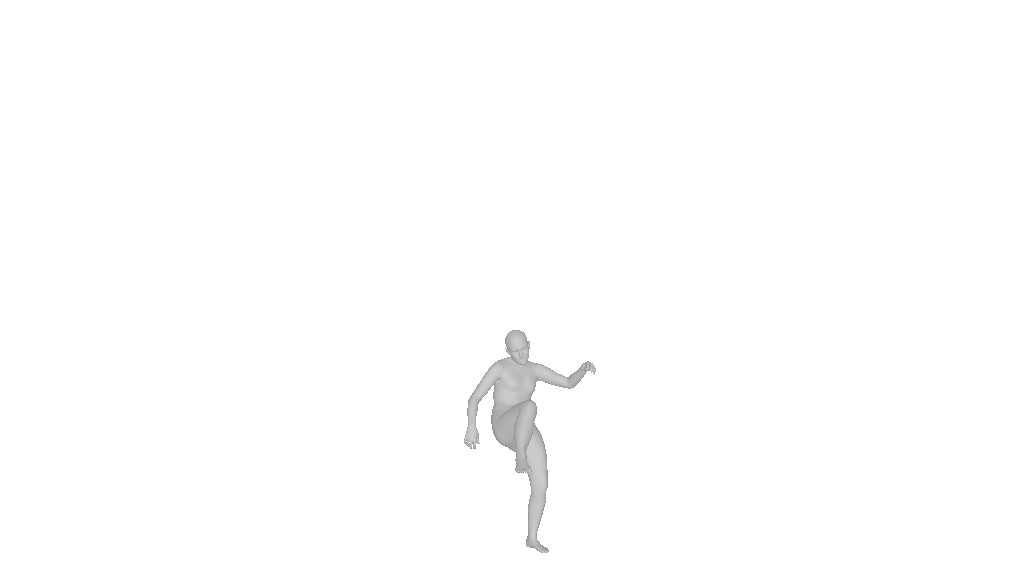

In [28]:
smpl_params_c = {k:v.to(device) for k,v in batch['smpl_params_c'].items()}
verts = smplx(**smpl_params_c).vertices

renderer_c = Renderer(1024, 576, device="cuda", faces=smplx.faces, K=K_fullimg[0])
i = 25
img = renderer_c.render_mesh(verts[i])
Image.fromarray(img)

In [6]:
w_j3d = smplx(**{k:v.to(device) for k,v in smpl_params_w.items()}).joints.cpu()
# width, height, K_fullimg = create_camera_sensor(1000, 1000, 24) 
# wham_cam_augmentor = CameraAugmentorV11()
# T_w2c = wham_cam_augmentor(w_j3d, motion_frames_len) 
c_j3d = apply_T_on_points(w_j3d[:,:22], T_w2c)
verts, faces, vertex_colors = convert_motion_as_line_mesh(c_j3d)

renderer = Renderer(width, height, device="cuda", faces=faces.cuda(), K=K_fullimg[0])
writer = get_writer(f'tmp3.mp4', fps=30, crf=23)
for i in tqdm(range(motion_frames_len), desc=f"Rendering Camera"):
    img_overlay_pred = renderer.render_mesh(verts[i].cuda(), None, colors=vertex_colors[None] / 255.0, VI=1)
    writer.write_frame(img_overlay_pred)
writer.close()

Rendering Camera: 100%|██████████| 120/120 [00:04<00:00, 29.05it/s]


In [7]:
kp3d = smplx_coco(**{k: v.to(device) for k,v in batch['smpl_params_w'].items()})
np.save("coco_17joints.npy", kp3d.cpu().float().numpy())

smplx_out = smplx(**{k: v.to(device) for k,v in batch['smpl_params_w'].items()})
np.save("full_vertices.npy", smplx_out.vertices.cpu().float().numpy())
np.save("full_joints.npy", smplx_out.joints.cpu().float().numpy())

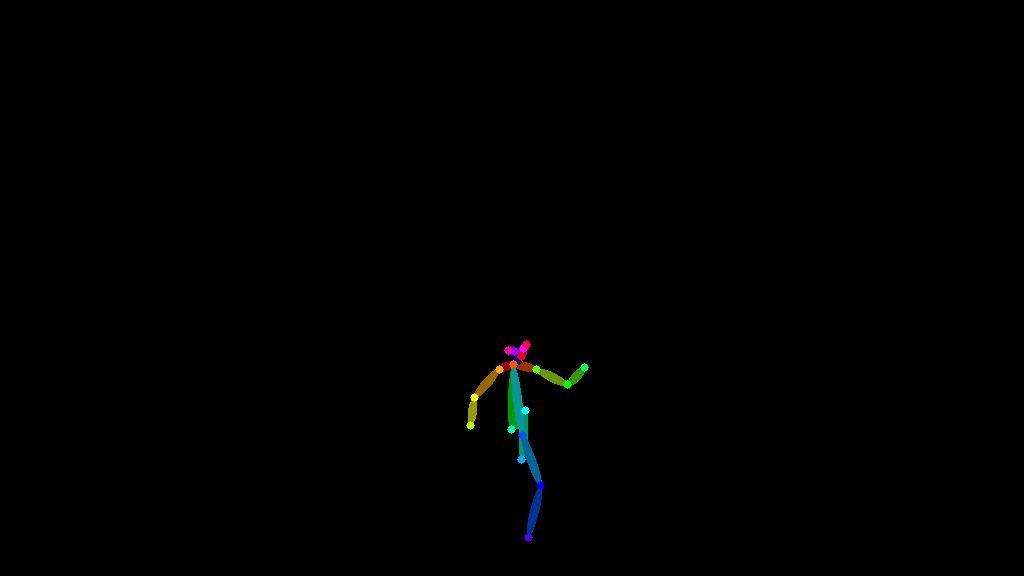

In [35]:
from hmr4d.utils.open_pose.body import Keypoint
from hmr4d.utils.open_pose.util import draw_bodypose

smpl_params_c = {k:v.to(device) for k,v in batch['smpl_params_c'].items()}
joints = smplx(**smpl_params_c).joints

openpose_idx = smpl_to_openpose(model_type='smplx', use_hands=False, use_face=False,
                     use_face_contour=False, openpose_format='coco19')
openpose_idx = openpose_idx[list(range(0,8))+list(range(9,19))]
openpose_joints = joints[i:i+1, openpose_idx]

pred_c_joints, pred_c_valid = renderer_c.project_points_to_full_image(openpose_joints)
image_sizes = [(576, 1024)]

# pts_screen = cameras.transform_points_screen(
#     openpose_joints, image_size=image_sizes
# )[..., :2]  # (N, J, 2)
# pts_screen_flipped = pts_screen.clone()
# pts_screen_flipped[..., 0] = (image_sizes[0][1] - 1) - pts_screen_flipped[..., 0]  # x
# pts_screen_flipped[..., 1] = (image_sizes[0][0] - 1) - pts_screen_flipped[..., 1]  # y
## Convert from cropped coords -> full-image coords by adding bbox top-left offset
# bbox = bboxes[0].int().to('cuda')  # (left, top, right, bottom)
# left, top = bbox[0], bbox[1]
# pts_full = pts_screen_flipped + torch.tensor([[[left, top]]], device='cuda')
# pred_c_joints = pts_screen_flipped

# z = cameras.transform_points(openpose_joints)[..., 2]  # camera-space z
# valid = (z > 1e-6)
# valid = valid & (pts_screen[..., 0] >= 0) & (pts_screen[..., 0] < image_sizes[0][1]) & (pts_screen[..., 1] >= 0) & (pts_screen[..., 1] < image_sizes[0][0])
# pred_c_valid = valid

keypoints=[
    Keypoint(
        x=keypoint[0].item() / float(image_sizes[0][1]), 
        y=keypoint[1].item() / float(image_sizes[0][0])) 
    if valid else None
    for keypoint, valid in zip(pred_c_joints[0], pred_c_valid[0])]

canvas = np.zeros(shape=(image_sizes[0][0], image_sizes[0][1], 3), dtype=np.uint8)
# canvas = image.copy()
canvas = draw_bodypose(canvas, keypoints)
Image.fromarray(canvas)

In [ ]:
renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K)

writer = get_writer('tmp.mp4', fps=30, crf=23)
for i in tqdm(range(length)):
    img = renderer_c.render_mesh(verts[i])
    writer.write_frame(img)
writer.close()

In [11]:
# smplx_out = smplx(**{
#     "body_pose": data["body_pose"].to(device),  # (F, 63)
#     "betas": betas.to(device),  # (F, 10)
#     "global_orient": global_orient_w.to(device),  # (F, 3)
#     "transl": transl_w.to(device),  # (F, 3)
# })
smplx_out = smplx(**{k: v.to(device) for k,v in batch['smpl_params_w'].items()})
pred_ay_verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in smplx_out.vertices])
pred_gb_verts, pred_gb_joints = move_to_start_point_face_z(pred_ay_verts, J_regressor)

global_R, global_T, global_lights = get_global_cameras_static(
    pred_gb_joints.cpu(), beta=2.0, cam_height_degree=20, target_center_height=1.0,
)
_, _, K = create_camera_sensor(width, height, 24)
renderer_g = Renderer(width, height, device="cuda", faces=faces_smpl[0], K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(pred_gb_joints[:, 0], pred_gb_verts)
renderer_g.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8

writer = get_writer(f'tmp2.mp4', fps=30, crf=23)
for i in tqdm(range(batch['length']), desc=f"Rendering Global"):
    # img_overlay_pred = renderer.render_mesh(verts[i].cuda(), bg, vertex_colors, VI=1)
    cameras = renderer_g.create_camera(global_R[i], global_T[i])
    img_gb = renderer_g.render_with_ground(pred_gb_verts[[i]], color[None], cameras, global_lights)
    writer.write_frame(img_gb)
writer.close()

Rendering Global: 100%|██████████| 120/120 [00:04<00:00, 25.50it/s]


In [ ]:
# from pytorch3d.renderer import PerspectiveCameras, PointLights, MeshRenderer, MeshRasterizer, RasterizationSettings, SoftPhongShader
# from pytorch3d.renderer import TexturesVertex, Materials
# from pytorch3d.structures import Meshes
# from hmr4d.utils.vis.renderer import perspective_projection, update_intrinsics_from_bbox, compute_bbox_from_points

# width, height, K = create_camera_sensor(1024, 576, 24)
# K = K.unsqueeze(0).float().to(device)
# print(K.v)

# ## Assume: verts, K
# R = torch.diag(torch.tensor([1, 1, 1])).unsqueeze(0).float().to(device)
# T = torch.tensor([0, 0, 0]).unsqueeze(0).float().to(device)

# i = 25
# verts_i = verts[i].unsqueeze(0)
# x3d = verts_i[:,::50].clone()
# x2d = perspective_projection(x3d, K.to(device), R, T[...,None])
# bboxes = compute_bbox_from_points(x2d, width, height, 2.0)
# K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)

# print(bboxes.v)
# print(K_full[:,:3,:3].v)
# print(K_full[:,:3,3].v)
# print(image_sizes)

# cameras = PerspectiveCameras(device=device, R=R.mT, T=T, K=K_full, image_size=image_sizes, in_ndc=False)
# lights = PointLights(device=device, location=[[0.0, 0.0, -10.0]])
# raster_settings = RasterizationSettings(image_size=image_sizes[0], blur_radius=1e-5, bin_size=None)
# rasterizer = MeshRasterizer(raster_settings=raster_settings)
# shader = SoftPhongShader(device=device, lights=lights)
# renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

# verts_features = torch.tensor([0.8,0.8,0.8]).reshape(1, 1, 3).to(device=device, dtype=verts_i.dtype)
# verts_features = verts_features.repeat(1, verts_i.shape[1], 1)
# textures = TexturesVertex(verts_features=verts_features)

# mesh = Meshes(verts=verts_i, faces=faces_smplx, textures=textures,)

# materials = Materials(device=device, specular_color=([0.8, 0.8, 0.8],), shininess=0)

# results = torch.flip(renderer(mesh, materials=materials, cameras=cameras, lights=lights), [1, 2])
# image = (results[0, ..., :3].detach().cpu().numpy() * 255).astype(np.uint8)
# mask = (results[0, ..., -1].detach().cpu().numpy() > 1e-3).astype(bool)
# Image.fromarray(image)